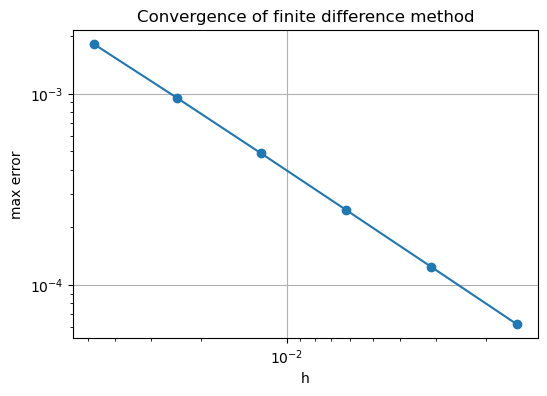

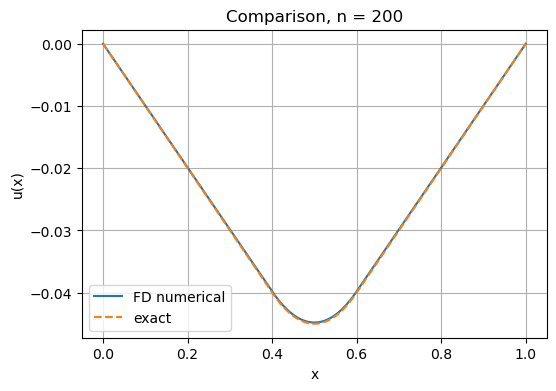

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#第一題
# -------------------------------------------------------------------
# 解析解 u(x)
# -------------------------------------------------------------------
def u_exact(x):
    x = np.asarray(x)
    u = np.zeros_like(x)

    # left part: 0 ≤ x ≤ 0.4
    mask1 = (x <= 0.4)
    u[mask1] = -0.1 * x[mask1]

    # middle part: 0.4 ≤ x ≤ 0.6
    mask2 = (x >= 0.4) & (x <= 0.6)
    u[mask2] = 0.5 * x[mask2]**2 - 0.5 * x[mask2] + 0.08

    # right part: 0.6 ≤ x ≤ 1
    mask3 = (x >= 0.6)
    u[mask3] = 0.1 * x[mask3] - 0.1

    return u


# -------------------------------------------------------------------
# f(x) piecewise
# -------------------------------------------------------------------
def f_func(x):
    return np.where((x >= 0.4) & (x <= 0.6), 1.0, 0.0)


# -------------------------------------------------------------------
# Finite difference solver for u'' = f, u(0)=u(1)=0
# -------------------------------------------------------------------
def solve_fd(n):
    h = 1.0 / (n + 1)
    x = np.linspace(0, 1, n+2)

    # interior grid
    xi = x[1:-1]

    # assemble A matrix (tridiagonal)
    A = np.zeros((n, n))
    np.fill_diagonal(A, -2)
    np.fill_diagonal(A[1:], 1)
    np.fill_diagonal(A[:,1:], 1)
    A = A / h**2

    # RHS
    b = f_func(xi)

    u_interior = np.linalg.solve(A, b)

    # add boundaries
    u = np.zeros_like(x)
    u[1:-1] = u_interior
    return x, u


# -------------------------------------------------------------------
# Error vs h study
# -------------------------------------------------------------------
hs = []
errs = []

for n in [20, 40, 80, 160, 320, 640]:
    x, u_num = solve_fd(n)
    u_ex = u_exact(x)
    errs.append(np.max(np.abs(u_num - u_ex)))
    hs.append(1/(n+1))


# -------------------------------------------------------------------
# Plot error
# -------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.loglog(hs, errs, 'o-', base=10)
plt.gca().invert_xaxis()
plt.xlabel("h")
plt.ylabel("max error")
plt.title("Convergence of finite difference method")
plt.grid(True)
plt.show()


# -------------------------------------------------------------------
# Plot one example solution
# -------------------------------------------------------------------
x, u_num = solve_fd(200)
plt.figure(figsize=(6,4))
plt.plot(x, u_num, label="FD numerical")
plt.plot(x, u_exact(x), '--', label="exact")
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparison, n = 200")
plt.grid(True)
plt.show()


把解分為三段求解，其中係數可以透過u(x)及其導數u'(x)在0.4和0.6相等來得出，可以驗證得到的解有滿足邊界條件
0≤x≤0.4時 u(x)=-0.1x

0.4≤x≤0.6時 u(x)=x^2/2-0.5x+0.08

0.6≤x≤1時 u(x)=0.1x-0.1

誤差會呈現一條接近 O(h^2) 的直線(因為 central difference 是二階)

N=  20, h=5.00000e-02, max error = 1.328e-03
N=  40, h=2.50000e-02, max error = 3.433e-04
N=  80, h=1.25000e-02, max error = 8.733e-05
N= 160, h=6.25000e-03, max error = 2.203e-05
N= 320, h=3.12500e-03, max error = 5.531e-06


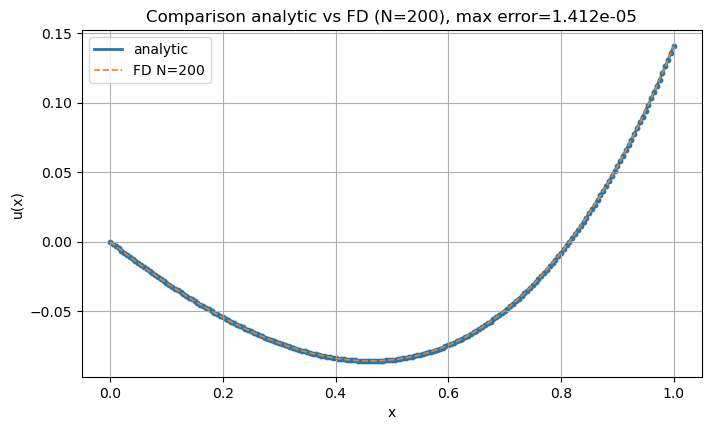

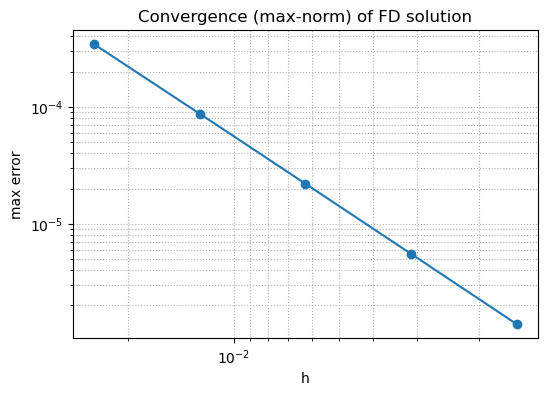

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#第二題
# -------------------------
# analytic solution
# -------------------------
def u_analytic(x):
    # exact solution: u(x) = (-1 + C2 x) e^x + 1,  C2 = (1 + e^{-1})/2
    C2 = 0.5 * (1.0 + np.exp(-1.0))
    return (-1.0 + C2 * x) * np.exp(x) + 1.0

# -------------------------
# build FD linear system for given N (h = 1/N)
# unknowns: u1,...,uN  (u0=0 known)
# -------------------------
def build_system(N):
    """
    N: number of subintervals, h = 1/N, nodes x_j = j*h, j=0..N
    unknown vector is [u1,...,uN] (size N)
    returns A (NxN), b (N)
    """
    h = 1.0 / N
    n = N  # number of unknowns
    A = np.zeros((n, n))
    b = np.zeros(n)

    # interior equations j = 1..N-1 correspond to rows 0..N-2
    # coefficients from formula:
    # (1+h) u_{j-1} + (-2 + h^2) u_j + (1-h) u_{j+1} = h^2
    a = 1.0 + h       # lower diag (coefficient for u_{j-1})
    bdiag = -2.0 + h*h  # main diag
    c = 1.0 - h       # upper diag

    # fill rows for j=1..N-1
    for j in range(1, N):  # j is grid index
        row = j - 1        # row index in matrix
        # u_{j-1} corresponds to unknown index j-2 (if j-1 >=1)
        if j - 1 >= 1:
            A[row, (j-1)-1] = a
        else:
            # j-1 == 0 -> u0 known (u0=0), move to RHS: a * u0
            # since u0=0, no contribution
            pass
        # u_j -> unknown index j-1
        A[row, j-1] = bdiag
        # u_{j+1} -> unknown index j (exists because j <= N-1)
        A[row, j] = c
        # RHS
        b[row] = h*h

    # Now Neumann equation at x_N (row N-1)
    # 3 u_N - 4 u_{N-1} + 1 u_{N-2} = 2 h
    # map to unknown indices: u_{N-2} -> index N-3, u_{N-1} -> N-2, u_N -> N-1
    if N >= 2:
        A[N-1, N-3] = 1.0
        A[N-1, N-2] = -4.0
        A[N-1, N-1] = 3.0
    else:
        # degenerate small N case: N==1, only u1 unknown; Neumann uses u_{-1} nonexistent.
        # but for correctness require N>=2 in practice. We'll not run N<2.
        raise ValueError("N must be >= 2")

    b[N-1] = 2.0 * h

    return A, b

# solve for different grid sizes and compute error
def solve_and_report(N):
    A, rhs = build_system(N)
    u_unknown = np.linalg.solve(A, rhs)
    # assemble full solution including u0=0
    u_full = np.zeros(N+1)
    u_full[1:] = u_unknown  # u1..uN
    x = np.linspace(0.0, 1.0, N+1)
    u_exact = u_analytic(x)
    max_err = np.max(np.abs(u_full - u_exact))
    return x, u_full, u_exact, max_err

# Example runs
for N in [20, 40, 80, 160, 320]:
    x, u_num, u_ex, err = solve_and_report(N)
    print(f"N={N:4d}, h={1/N:.5e}, max error = {err:.3e}")

# plot example: compare numerical and analytic for a fine grid
Nplot = 200
x, u_num, u_ex, err = solve_and_report(Nplot)
plt.figure(figsize=(8,4.5))
plt.plot(x, u_ex, label='analytic', linewidth=2)
plt.plot(x, u_num, '--', label=f'FD N={Nplot}', linewidth=1.2)
plt.scatter(x, u_num, s=10)
plt.xlabel('x'); plt.ylabel('u(x)')
plt.legend(); plt.grid(True)
plt.title(f'Comparison analytic vs FD (N={Nplot}), max error={err:.3e}')
plt.show()

# convergence plot
Ns = [40, 80, 160, 320, 640]
hs = []
errs = []
for N in Ns:
    _, _, _, err = solve_and_report(N)
    hs.append(1.0/N)
    errs.append(err)

plt.figure(figsize=(6,4))
plt.loglog(hs, errs, 'o-', base=10)
plt.gca().invert_xaxis()
plt.xlabel('h')
plt.ylabel('max error')
plt.title('Convergence (max-norm) of FD solution')
plt.grid(True, which='both', ls=':')
plt.show()


N=  20, h=5.0000e-02, max error (after shift) = 1.311e-03
N=  40, h=2.5000e-02, max error (after shift) = 3.274e-04
N=  80, h=1.2500e-02, max error (after shift) = 8.182e-05
N= 160, h=6.2500e-03, max error (after shift) = 2.045e-05
N= 320, h=3.1250e-03, max error (after shift) = 5.113e-06
N= 640, h=1.5625e-03, max error (after shift) = 1.278e-06


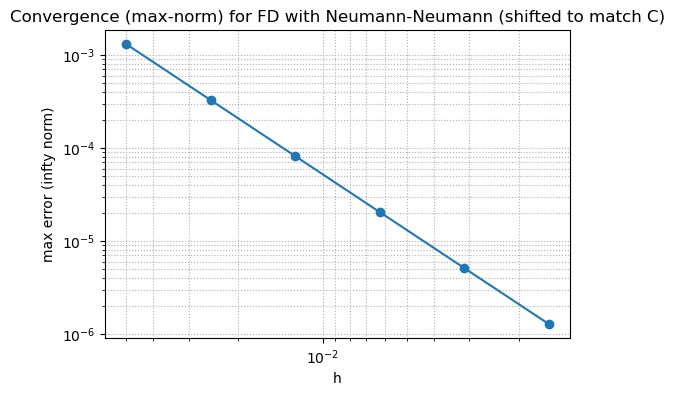

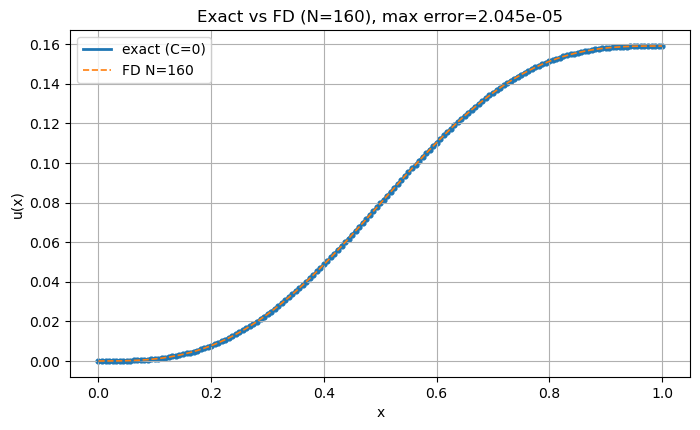

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#第三題
# exact solution (choose C=0)
def u_exact(x):
    return x/(2*np.pi) - np.sin(2*np.pi*x)/(4*np.pi**2)

# right-hand side f(x) = sin(2πx)
def f_rhs(x):
    return np.sin(2*np.pi*x)

# build (N+1)x(N+1) matrix including ghost elimination for Neumann at both ends
def build_matrix_and_rhs(N):
    # nodes i=0..N, h=1/N
    h = 1.0 / N
    x = np.linspace(0.0, 1.0, N+1)
    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)

    # interior rows i = 1..N-1
    for i in range(1, N):
        A[i, i-1] = 1.0 / h**2
        A[i, i]   = -2.0 / h**2
        A[i, i+1] = 1.0 / h**2
        b[i] = f_rhs(x[i])

    # left boundary i = 0, using ghost u_{-1}=u_1 => u''(0) ≈ (2u1 - 2u0)/h^2 = f(x0)
    A[0, 0] = -2.0 / h**2
    A[0, 1] = 2.0 / h**2
    b[0] = f_rhs(x[0])

    # right boundary i = N, ghost u_{N+1}=u_{N-1} => u''(1) ≈ (2 u_{N-1} - 2 u_N)/h^2 = f(xN)
    A[N, N]     = -2.0 / h**2
    A[N, N-1]   = 2.0 / h**2
    b[N] = f_rhs(x[N])

    return A, b, x

# solve via least squares (works even if A is singular but consistent)
def solve_fd_neumann(N):
    A, b, x = build_matrix_and_rhs(N)
    # use lstsq to obtain one solution (minimal norm)
    u_sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    return x, u_sol

# compute error after shifting constant so u_num(0) == u_exact(0)
def shifted_error(u_num, x, u_exact_func):
    # shift so u_num(0) = u_exact(0)
    shift = u_exact_func(0.0) - u_num[0]
    u_num_shifted = u_num + shift
    u_ex = u_exact_func(x)
    err = np.max(np.abs(u_num_shifted - u_ex))
    return err, u_num_shifted, u_ex

# run convergence study
Ns = [20, 40, 80, 160, 320, 640]
hs = []
errs = []
solutions = {}

for N in Ns:
    x, u_num = solve_fd_neumann(N)
    err, u_shifted, u_ex = shifted_error(u_num, x, u_exact)
    hs.append(1.0/N)
    errs.append(err)
    solutions[N] = (x, u_shifted, u_ex)
    print(f"N={N:4d}, h={1/N:.4e}, max error (after shift) = {err:.3e}")

# plot convergence
plt.figure(figsize=(6,4))
plt.loglog(hs, errs, 'o-', base=10)
plt.gca().invert_xaxis()
plt.xlabel('h')
plt.ylabel('max error (infty norm)')
plt.title('Convergence (max-norm) for FD with Neumann-Neumann (shifted to match C)')
plt.grid(True, which='both', ls=':')
plt.show()

# plot solution for a representative N
Nplot = 160
x_plot, u_num_plot, u_ex_plot = solutions[Nplot]
plt.figure(figsize=(8,4.5))
plt.plot(x_plot, u_ex_plot, label='exact (C=0)', linewidth=2)
plt.plot(x_plot, u_num_plot, '--', label=f'FD N={Nplot}', linewidth=1.2)
plt.scatter(x_plot, u_num_plot, s=12)
plt.xlabel('x'); plt.ylabel('u(x)')
plt.legend(); plt.grid(True)
plt.title(f'Exact vs FD (N={Nplot}), max error={np.max(np.abs(u_num_plot-u_ex_plot)):.3e}')
plt.show()


N=   40, h=2.500e-02, max error = 5.461865e-01
N=   80, h=1.250e-02, max error = 1.565407e-01
N=  160, h=6.250e-03, max error = 3.397533e-02
N=  320, h=3.125e-03, max error = 8.458388e-03
N=  640, h=1.563e-03, max error = 2.097005e-03
N= 1280, h=7.813e-04, max error = 5.241527e-04


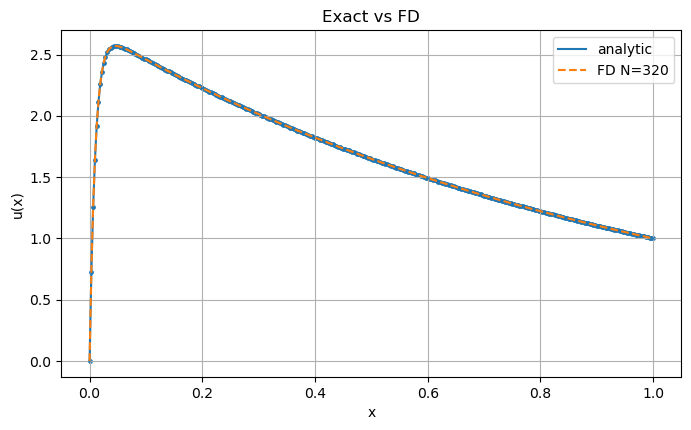

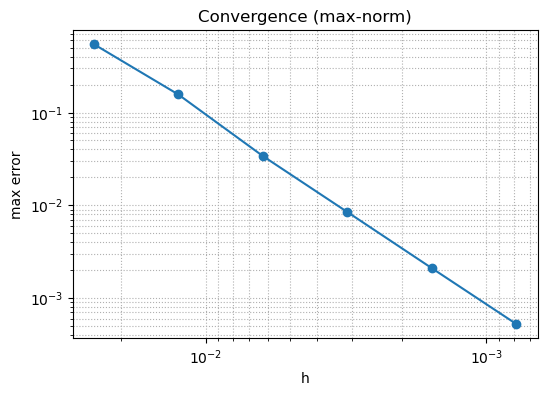

Estimated order (slope) from log-log fit: 2.0228050731945078


In [8]:
import numpy as np
import matplotlib.pyplot as plt

#第五題
# ---- parameters ----
eps = 0.01

# analytic solution (using the exact C1 formula)
r1 = -1.0
r2 = -100.0
C1 = 1.0 / (np.exp(r1) - np.exp(r2))   # exact
def u_exact(x):
    return C1 * (np.exp(r1 * x) - np.exp(r2 * x))

# ---- finite-difference builder and solver ----
def build_fd_system(N, eps):
    """
    N: number of subintervals (so there are N+1 grid points)
    returns A ( (N-1)x(N-1) ), b (N-1)
    unknowns are u_1 .. u_{N-1}; u_0=0, u_N=1 (Dirichlet)
    """
    h = 1.0 / N
    m = N - 1
    A = np.zeros((m, m))
    b = np.zeros(m)
    # coefficients (derived from discretization)
    a_im1 = eps - (1.0 + eps) * (h/2.0)
    a_i   = -2.0*eps + h*h
    a_ip1 = eps + (1.0 + eps) * (h/2.0)
    for j in range(1, N):   # j indexes actual grid point
        row = j - 1
        if row - 1 >= 0:
            A[row, row-1] = a_im1
        A[row, row] = a_i
        if row + 1 <= m - 1:
            A[row, row+1] = a_ip1
        # right-hand side: if u_{j+1} is boundary u_N (=1), move its contribution to b
        if j == N-1:
            b[row] = - a_ip1 * 1.0
    return A, b

def solve_fd(N, eps):
    A, b = build_fd_system(N, eps)
    u_interior = np.linalg.solve(A, b)         # solve for u_1..u_{N-1}
    u = np.zeros(N+1)
    u[0] = 0.0
    u[1:-1] = u_interior
    u[-1] = 1.0
    x = np.linspace(0.0, 1.0, N+1)
    return x, u

# ---- convergence study ----
Ns = [40, 80, 160, 320, 640, 1280]
hs = []
errs = []
for N in Ns:
    x, u_num = solve_fd(N, eps)
    u_ex = u_exact(x)
    err = np.max(np.abs(u_num - u_ex))
    hs.append(1.0/N)
    errs.append(err)
    print(f"N={N:5d}, h={1.0/N:.3e}, max error = {err:.6e}")

# plot example (compare analytic vs numerical for one N)
Nplot = 320
xplot, unum_plot = solve_fd(Nplot, eps)
uex_plot = u_exact(xplot)
plt.figure(figsize=(8,4.5))
plt.plot(xplot, uex_plot, label='analytic')
plt.plot(xplot, unum_plot, '--', label=f'FD N={Nplot}')
plt.scatter(xplot, unum_plot, s=6)
plt.legend(); plt.xlabel('x'); plt.ylabel('u(x)'); plt.grid(True); plt.title('Exact vs FD')
plt.show()

# convergence log-log plot
plt.figure(figsize=(6,4))
plt.loglog(hs, errs, 'o-')
plt.gca().invert_xaxis()
plt.xlabel('h'); plt.ylabel('max error'); plt.title('Convergence (max-norm)')
plt.grid(True, which='both', ls=':')
plt.show()

# estimated order of convergence (slope)
p = np.polyfit(np.log(hs), np.log(errs), 1)
print("Estimated order (slope) from log-log fit:", p[0])
